In [1]:
%pylab inline
import matplotlib.pyplot as plt
import pylab as pl
#from sklearn.cross_validation import train_test_split
import scipy
import seaborn as sns
from spectral import imshow
from collections import Counter
import random
import pickle
pl.gray()

Populating the interactive namespace from numpy and matplotlib


In [2]:
##loading images for input and target image
import scipy.io as io
input_image = io.loadmat('Indian_pines.mat')['indian_pines']
target_image = io.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

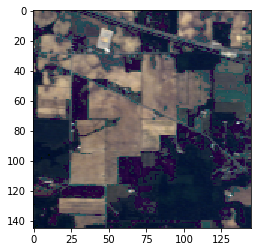

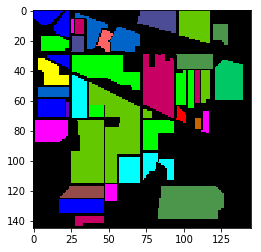

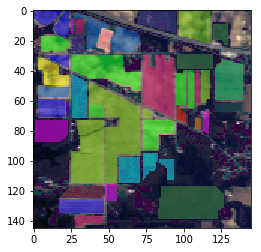

In [3]:
# plotting the input and target image
ip = imshow(input_image,(29, 19, 9))
tg = imshow(classes = target_image)
view = imshow(input_image, (30, 20, 10), classes=target_image)
view.set_display_mode('overlay')
view.class_alpha = 0.5


In [4]:
#Reshaping the images to python convention
input_image = input_image.transpose((2,0,1))
input_image_height = input_image.shape[1]
input_image_width = input_image.shape[2]

print (input_image_height,'x',input_image_width)
print (len(input_image),'x',len(input_image[0]),'x',len(input_image[0][0]))

145 x 145
220 x 145 x 145


In [5]:
## Scaling Down the image to 0 - 1

input_image = input_image.astype(float)
input_image -= np.min(input_image)
input_image /= np.max(input_image) - np.min(input_image) + 1

In [6]:
## Preparing patches

PATCH_SIZE = 5
input_patches = []
targets = []

for i in range(input_image_height-PATCH_SIZE+1):
    for j in range(input_image_width-PATCH_SIZE+1):

        height_slice = slice(i, i+PATCH_SIZE)
        width_slice = slice(j, j+PATCH_SIZE)
      
        patch = input_image[:, height_slice, width_slice]
    
        #We pick the target label as the label of the central pixel of the patch
        target = int(target_image[i+PATCH_SIZE//2, j+ PATCH_SIZE//2])
        if target==0:
            continue
        else:
            targets.append(target)
            input_patches.append(patch)

In [7]:
# #Checking the distribution of data samples
# sns.countplot(targets)
# plt.title('Class distribution')
# plt.show()

In [8]:
## Converting input_patches and targets to numpy arrays 
input_patches = np.array(input_patches)
targets = np.array(targets)

In [9]:
## oversampling to remove class imbalance
unq, unq_idx = np.unique(targets, return_inverse=True)
unq_cnt = np.bincount(unq_idx)
cnt = np.max(unq_cnt)
n_targets = np.empty((cnt*len(unq),) + targets.shape[1:], targets.dtype)
n_input_patches = np.empty((cnt*len(unq),) + input_patches.shape[1:], input_patches.dtype)
for j in range(len(unq)):
    indices = np.random.choice(np.where(unq_idx==j)[0], cnt)
    n_targets[j*cnt:(j+1)*cnt] = targets[indices]
    n_input_patches[j*cnt:(j+1)*cnt] = input_patches[indices]
    

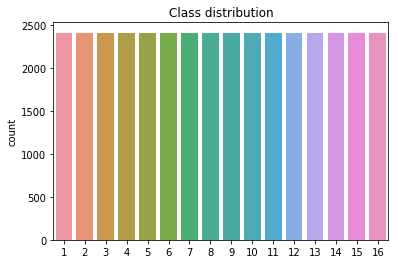

In [10]:
sns.countplot(n_targets)
plt.title('Class distribution')
plt.show()

In [11]:
## Mean Normalization

for i in range(len(n_input_patches)):
    for j in range(len(n_input_patches[i])):
        n_input_patches[i][j] -= np.mean(n_input_patches[i][j])

In [17]:
#------------------------Making train and test splits---------------------
counter = Counter(n_targets)
counter = dict(counter)
train_count = {}
test_count = {}

for label in counter.keys():
	test_count[label] = int(counter[label]/10)
	train_count[label] = int(counter[label] - test_count[label])

train_patches = []
test_patches = []
train_labels = []
test_labels = []
all_patches = {}

for i in range(len(n_input_patches)):
	if n_targets[i] not in all_patches.keys() : all_patches[n_targets[i]] = []
	all_patches[n_targets[i]].append(n_input_patches[i])

for label in train_count.keys():
	patches = all_patches[label]
	train_patches += patches[:train_count[label]]
	test_patches += patches[train_count[label]:]
	train_labels += [label]*train_count[label]
	test_labels += [label]*test_count[label]

train_zip = zip(train_patches, train_labels)
test_zip = zip(test_patches, test_labels)
# random.shuffle(train_zip)
# random.shuffle(test_zip)
train_patches, train_labels = zip(*train_zip)
test_patches, test_labels = zip(*test_zip)
train_patches = list(train_patches)
train_labels = list(train_labels)
test_patches = list(test_patches)
test_labels = list(test_labels)


In [19]:
for i in range(31):
    train_dict = {}
    if i == 30:
        start = i * 1000
        end = len(train_patches) + 1
    else:    
        start = i * 1000
        end = (i+1) * 1000
    file_name = "./" + str(i) + ".mat"
    train_dict["train_patch"] = train_patches[start:end]
    train_dict["train_labels"] = train_labels[start:end]
    io.savemat(file_name,train_dict)

In [20]:
for i in range(3):
    test_dict = {}
    if i == 2:
        start = i * 1000
        end = len(test_patches) + 1
    else:
        start = i * 1000
        end = (i+1) * 1000
    file_name = "./" + str(i) + ".mat"
    test_dict["test_patch"] = test_patches[start:end]
    test_dict["test_labels"] = test_labels[start:end]
    io.savemat(file_name,test_dict)